# Глубокое обучение в компьютерном зрении. Интерактивный курс
## Обработка видео
### Обучить нейронную сеть для распознавания действий человека по видео на датасете KTH
### Библиотеки: [Python, Tensorflow]

In [1]:
!pip install scikit-video==1.1.11
!pip uninstall -y tensorflow && pip install -q tensorflow==2.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 4.8 MB/s 
Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
  Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949
     |████████████████████████████████| 421.8 MB 26 kB/s 
     |████████████████████████████████| 50 kB 8.4 MB/s 
     |████████████████████████████████| 448 kB 67.9 MB/s 
     |████████████████████████████████| 3.8 MB 48.7 MB/s 
     |████████████████████████████████| 26.1 MB 1.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.16.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.4.1 which is incompatible.
p

In [2]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import skvideo.io

In [3]:
# !rm -rf walking
# !rm -rf jogging
# !rm -rf running
# !rm -rf boxing
# !rm -rf handwaving
# !rm -rf handclapping

In [4]:
!mkdir -p walking && cd walking && wget http://www.csc.kth.se/cvap/actions/walking.zip
!mkdir -p jogging && cd jogging && wget http://www.csc.kth.se/cvap/actions/jogging.zip
!mkdir -p running && cd running && wget http://www.csc.kth.se/cvap/actions/running.zip
!mkdir -p boxing && cd boxing && wget http://www.csc.kth.se/cvap/actions/boxing.zip
!mkdir -p handwaving && cd handwaving && wget http://www.csc.kth.se/cvap/actions/handwaving.zip
!mkdir -p handclapping && cd handclapping && wget http://www.csc.kth.se/cvap/actions/handclapping.zip

--2022-08-24 16:41:29--  http://www.csc.kth.se/cvap/actions/walking.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.28.41|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.csc.kth.se/cvap/actions/walking.zip [following]
--2022-08-24 16:41:30--  https://www.csc.kth.se/cvap/actions/walking.zip
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.28.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242442411 (231M) [application/zip]
Saving to: ‘walking.zip’

walking.zip         100%[===================>] 231.21M  1.06MB/s    in 3m 43s  

2022-08-24 16:45:13 (1.04 MB/s) - ‘walking.zip’ saved [242442411/242442411]

URL transformed to HTTPS due to an HSTS policy
--2022-08-24 16:45:14--  https://www.csc.kth.se/cvap/actions/jogging.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c2

In [5]:
!cd walking && unzip -q walking.zip
!cd jogging && unzip -q jogging.zip
!cd running && unzip -q running.zip
!cd boxing && unzip -q boxing.zip
!cd handwaving && unzip -q handwaving.zip
!cd handclapping && unzip -q handclapping.zip

# Attempt 1

In [6]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

dataset = []

data_root = '/content/'
for cls in classes:
    print(f'Processing class: {cls}')
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
        cls_idx = classes.index(cls)
        dataset.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


In [7]:
TRAIN_LEN = 180
TEST_LEN = 30
random.shuffle(dataset)
train = dataset[:TRAIN_LEN]
test = dataset[TRAIN_LEN: (TRAIN_LEN + TEST_LEN)]

print('Train samples (subset):', len(train))
print('Test samples (subset):', len(test))

Train samples (subset): 180
Test samples (subset): 30


In [8]:
train_shapes = []
for i in range(len(train)):
    videodata = skvideo.io.vread(train[i][0])
    train_shapes.append(videodata.shape)
train_shapes = sorted(train_shapes)

test_shapes = []
for i in range(len(test)):
    videodata = skvideo.io.vread(test[i][0])
    test_shapes.append(videodata.shape)
train_shapes = sorted(train_shapes)

videodata shape: (345, 120, 160, 3)


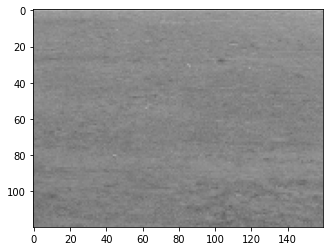

In [9]:
videodata = skvideo.io.vread(train[2][0])
videodata = videodata.astype(np.float32) / 255.
print('videodata shape:', videodata.shape)
plt.imshow(videodata[50, ...])

motion shape: (344, 120, 160, 1)


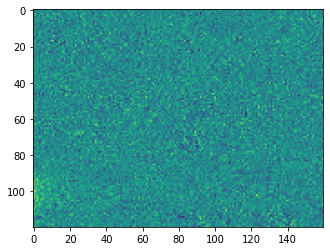

In [10]:
motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
print('motion shape:', motion.shape)
plt.imshow(motion[50, ..., 0])

In [11]:
path_to_train_video = []
train_labels = []
for tpl in train:
    path_to_train_video.append(tpl[0])
    train_labels.append(tpl[1])

In [12]:
path_to_test_video = []
test_labels = []
for tpl in test:
    path_to_test_video.append(tpl[0])
    test_labels.append(tpl[1])

In [13]:
def from_item_to_video(path_to_video):
    videodata = skvideo.io.vread(path_to_video.numpy().decode())
    videodata = videodata.astype(np.float32) / 255.
    return videodata

In [14]:
def prepare(path_to_video, labels):
    videodata = tf.py_function(from_item_to_video, [path_to_video], [tf.float32])
    return videodata, labels

In [15]:
train_ds = tf.data.Dataset.from_tensor_slices((path_to_train_video, train_labels))
train_ds = train_ds.shuffle(buffer_size=len(path_to_train_video), reshuffle_each_iteration=True)
train_ds = train_ds.map(prepare, num_parallel_calls=1)

test_ds = tf.data.Dataset.from_tensor_slices((path_to_test_video, test_labels))
test_ds = test_ds.shuffle(buffer_size=len(path_to_train_video), reshuffle_each_iteration=True)
test_ds = test_ds.map(prepare, num_parallel_calls=1)

In [16]:
class CBR(tf.keras.layers.Layer):
    
    def __init__(self, filters, kernel_size, strides, **kwargs):
        super().__init__()        
        self.conv = tf.keras.layers.Conv3D(filters, kernel_size, strides, **kwargs)
        self.bn = tf.keras.layers.BatchNormalization()
        
    def call(self, inp, training=False):
        out = self.conv(inp)
        out = self.bn(out, training)
        out = tf.nn.relu(out)        
        return out

In [17]:
WEIGHT_DECAY = 0.001

wd = tf.keras.regularizers.l2(WEIGHT_DECAY)

def build_model():
    x = tf.keras.layers.Input(shape=(None, None, None, 3))
    
    out = CBR(32, (5, 5, 5), (1, 2, 2), padding='same', kernel_regularizer=wd)(x)
    out = tf.keras.layers.MaxPool3D((1, 2, 2), padding='same')(out)

    out = CBR(64, (5, 5, 5), (1, 2, 2), padding='same', kernel_regularizer=wd)(out)
    out = tf.keras.layers.MaxPool3D((1, 2, 2), padding='same')(out)

    out = CBR(64, (5, 5, 5), (1, 2, 2), padding='same', kernel_regularizer=wd)(out)
    out = tf.keras.layers.MaxPool3D((1, 2, 2), padding='same')(out)

    out = tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None, kernel_regularizer=wd)(out)
    out = tf.keras.layers.BatchNormalization()(out)

    out = tf.keras.layers.GlobalAveragePooling3D()(out)

    out = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=wd)(out)
    out = tf.keras.layers.Dropout(0.5)(out)
    out = tf.keras.layers.Dense(6, activation=None)(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

In [18]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    )

In [19]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='/content/logs', 
    write_graph=False, update_freq=100, profile_batch=0)

In [20]:
%%time

NUM_EPOCHS = 10
history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=test_ds,
    callbacks=[tensorboard_callback])

ValueError: ignored

#Attempt 2

videodata shape: (655, 120, 160, 3)
class: handwaving


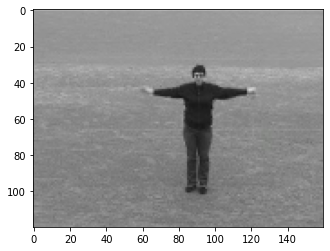

In [25]:
videodata = skvideo.io.vread(dataset[0][0])
videodata = videodata.astype(np.float32) / 255.
print('videodata shape:', videodata.shape)
print('class:', classes[dataset[0][1]])
plt.imshow(videodata[50, ...])

motion shape: (654, 120, 160, 1)


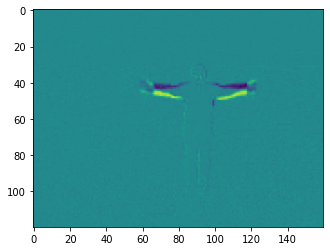

In [26]:
motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
print('motion shape:', motion.shape)
plt.imshow(motion[50, ..., 0])

In [69]:
TRAIN_SUBSET_LEN = 180
TEST_SUBSET_LEN = 30

train_x = [p for p, _ in dataset][:TRAIN_SUBSET_LEN]
train_y = [i for _, i in dataset][:TRAIN_SUBSET_LEN]
test_x = [p for p, _ in dataset][TRAIN_SUBSET_LEN : TRAIN_SUBSET_LEN + TEST_SUBSET_LEN]
test_y = [i for _, i in dataset][TRAIN_SUBSET_LEN : TRAIN_SUBSET_LEN + TEST_SUBSET_LEN]

print('Train samples (subset):', len(train_x))
print('Test samples (subset):', len(test_x))

Train samples (subset): 180
Test samples (subset): 30


In [70]:
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
test_ds = tf.data.Dataset.from_tensor_slices((test_x, test_y))

In [77]:
BATCH_SIZE = 1

train_ds = train_ds.shuffle(buffer_size=len(list(train_ds)))
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)

In [78]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation=None),
])

In [79]:
inp = motion[None, ...]
out = model(inp)

print('Input shape:', inp.shape)
print('Output shape:', out.shape)

Input shape: (1, 654, 120, 160, 1)
Output shape: (1, 6)


In [81]:
def prepare(path, label):
    # print(bytes.decode(path.numpy()[0]))
    videodata = skvideo.io.vread(bytes.decode(path.numpy()[0]))
    videodata = videodata.astype(np.float32) / 255.
    motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
    x = motion[None, ...]
    y = np.array(label)[None, ...]
    return x, y

In [83]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE)) #,
    # metrics=['accuracy'])

writer = tf.summary.create_file_writer('/content/logs')

In [84]:
import logging
logging.getLogger('tensorflow').setLevel(logging.INFO)

In [86]:
%%time

global_step = 0
for ep in range(NUM_EPOCHS):
    for iter, (fpath, label) in enumerate(train_ds):
        
        x, y = prepare(fpath, label)

        loss_value = model.train_on_batch(x, y)

        if iter % 10 == 0:
            accuracy_values = []
            for it, (fpath_t, label_t) in enumerate(test_ds):
                x, y = prepare(fpath_t, label_t)
                # print(f'label: {label_t[0]}')
                
                test_logits = model(x)[0]
                cls_pred = np.argmax(test_logits.numpy())

                accuracy_values.append(1 if cls_pred == label_t[0] else 0)
            print(f'[{ep+1}/{NUM_EPOCHS}][{iter+1}/{len(train_ds)}]\t'
                f'Loss: {loss_value:.4f}\tTest accuracy: {np.mean(accuracy_values):.4f}')

            with writer.as_default():
                tf.summary.scalar('loss', loss_value, global_step)

        global_step += 1

TypeError: ignored

# Attempt 3

In [87]:
SUBSET_LEN = 180
TEST_LEN = 30

random.shuffle(dataset)
train_dataset = dataset[:SUBSET_LEN]
test_dataset = dataset[SUBSET_LEN:SUBSET_LEN+TEST_LEN]

videodata shape: (456, 120, 160, 3)


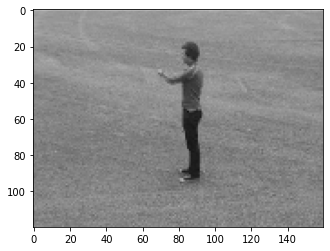

In [88]:
videodata = skvideo.io.vread(train_dataset[0][0])
videodata = videodata.astype(np.float32) / 255.
print('videodata shape:', videodata.shape)
plt.imshow(videodata[50, ...])

motion shape: (455, 120, 160, 1)


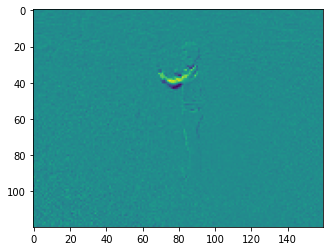

In [89]:
motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
print('motion shape:', motion.shape)
plt.imshow(motion[50, ..., 0])

In [90]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation=None),
])

In [91]:
inp = motion[None, ...]
out = model(inp)

print('Input shape:', inp.shape)
print('Output shape:', out.shape)

Input shape: (1, 455, 120, 160, 1)
Output shape: (1, 6)


In [92]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))

writer = tf.summary.create_file_writer('/content/logs')

In [93]:
%%time
global_step = 0
for ep in range(NUM_EPOCHS):
    for iter, (fpath, label) in enumerate(dataset):
        videodata = skvideo.io.vread(fpath)
        videodata = videodata.astype(np.float32) / 255.
        motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
        x = motion[None, ...]
        y = np.array(label)[None, ...]

        loss_value = model.train_on_batch(x, y)

        if iter % 10 == 0:
            print(f'[{ep}/{NUM_EPOCHS}][{iter}/{len(dataset)}] Loss = {loss_value}')

            with writer.as_default():
                tf.summary.scalar('loss', loss_value, global_step)

        global_step += 1

[0/10][0/599] Loss = 1.7947204113006592
[0/10][10/599] Loss = 2.4091672897338867
[0/10][20/599] Loss = 1.7789815664291382
[0/10][30/599] Loss = 1.8872346878051758
[0/10][40/599] Loss = 1.7515697479248047
[0/10][50/599] Loss = 1.8419729471206665
[0/10][60/599] Loss = 1.8339945077896118
[0/10][70/599] Loss = 1.8335134983062744
[0/10][80/599] Loss = 1.749854326248169
[0/10][90/599] Loss = 1.7658424377441406
[0/10][100/599] Loss = 1.8000165224075317
[0/10][110/599] Loss = 1.843796968460083
[0/10][120/599] Loss = 1.811356782913208
[0/10][130/599] Loss = 1.7714687585830688
[0/10][140/599] Loss = 1.8494479656219482
[0/10][150/599] Loss = 1.7647547721862793
[0/10][160/599] Loss = 1.8486377000808716
[0/10][170/599] Loss = 1.7622065544128418
[0/10][180/599] Loss = 1.8234643936157227
[0/10][190/599] Loss = 1.759440302848816
[0/10][200/599] Loss = 1.8043444156646729
[0/10][210/599] Loss = 1.8186933994293213
[0/10][220/599] Loss = 1.8288195133209229
[0/10][230/599] Loss = 1.7624757289886475
[0/10][

In [94]:
%load_ext tensorboard
%tensorboard --logdir logs

<IPython.core.display.Javascript object>

True class: boxing
Predicted class: walking


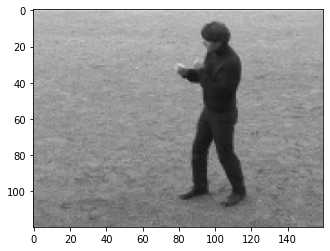

In [102]:
fpath, cls_true = random.choice(test_dataset)

videodata = skvideo.io.vread(fpath)
videodata = videodata.astype(np.float32) / 255.
plt.imshow(videodata[30, ...])

motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

out = model(motion[None, ...])[0]
cls_pred = np.argmax(out.numpy())

print('True class:', classes[cls_true])
print('Predicted class:', classes[cls_pred])